In [1]:
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer

import xgboost as xgb
from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('04-data/preprocessed_app_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22015 entries, 0 to 22014
Data columns (total 56 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   title                     22015 non-null  object 
 1   description               22015 non-null  object 
 2   summary                   22014 non-null  object 
 3   installs                  22015 non-null  object 
 4   minInstalls               22015 non-null  float64
 5   score                     22015 non-null  float64
 6   ratings                   22015 non-null  float64
 7   reviews                   22015 non-null  float64
 8   histogram                 22015 non-null  object 
 9   price                     22015 non-null  float64
 10  free                      22015 non-null  int64  
 11  currency                  22015 non-null  object 
 12  sale                      22015 non-null  bool   
 13  offersIAP                 22015 non-null  bool   
 14  inAppP

In [3]:
df_sentiment = pd.read_csv('merged_sentiment.csv')

In [4]:
df= pd.merge(
    df,
    df_sentiment,
    how="inner",
    on='title',
    left_index=False,
    right_index=False,
    sort=True,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
)

In [5]:
df = df[df['updated_year'] > 2013]

In [6]:
X = df[['ratings','free','containsAds','genre','editorsChoice','contentRating','year','top_developer',
        'installs_day','updated_days','has_video','compound']]

y = df['score']

In [7]:
# Split to create temporary tr and test 
X_tr, X_test, y_tr, y_test = train_test_split(X, y,test_size=.20, random_state=10)

In [8]:
X_tr_cont = X_tr[['ratings','free','containsAds','editorsChoice','top_developer',
        'installs_day','updated_days','has_video','compound']]

In [9]:
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(X_tr[['genre','contentRating','year']])

ohe_x_tr = ohe.transform(X_tr[['genre','contentRating','year']])

columns = ohe.get_feature_names(['genre','contentRating','year'])

ohe_x_tr_df = pd.DataFrame(ohe_x_tr, columns=columns, index=X_tr.index)

In [10]:
combo_train_df = pd.concat([X_tr_cont, ohe_x_tr_df], axis=1)

In [11]:
# Further split temporary tr to create train and val
X_train, X_val, y_train, y_val = train_test_split(combo_train_df, y_tr,test_size=.20, random_state=10)

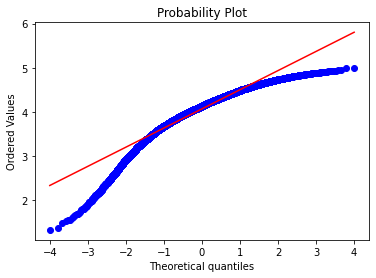

In [12]:
from scipy import stats 
fig = plt.figure() 
prob = stats.probplot(df['score'], plot=plt)

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


- Total number of ratings: 21888
- Mean of distribution of rating : 4.068367483223653
- Standard deviation: 0.4495861122060895


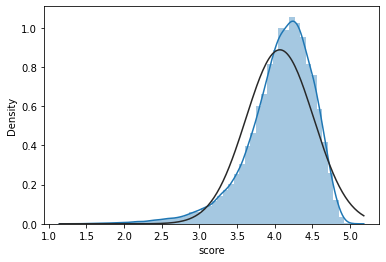

In [13]:
sns.distplot(df['score'],fit=stats.norm)
print('- Total number of ratings:', len(df['score']))
print('- Mean of distribution of rating :', np.mean(df['score']))
print('- Standard deviation:', np.std(df['score']))

## No pipeline

In [14]:
features = ['ratings', 'free', 'containsAds', 'editorsChoice',
       'top_developer', 'installs_day', 'updated_days', 'has_video',
       'compound', 'genre_Adventure', 'genre_Arcade', 'genre_Art & Design',
       'genre_Auto & Vehicles','genre_Beauty', 'genre_Board',
       'genre_Books & Reference', 'genre_Business', 'genre_Card',
       'genre_Casino', 'genre_Casual', 'genre_Comics', 'genre_Communication',
       'genre_Dating', 'genre_Education', 'genre_Entertainment',
       'genre_Events', 'genre_Finance', 'genre_Food & Drink',
       'genre_Health & Fitness', 'genre_House & Home',
       'genre_Libraries & Demo', 'genre_Lifestyle', 'genre_Maps & Navigation',
       'genre_Medical', 'genre_Music & Audio',
       'genre_News & Magazines', 'genre_Parenting', 'genre_Personalization',
       'genre_Photography', 'genre_Productivity', 'genre_Puzzle',
       'genre_Racing', 'genre_Role Playing', 'genre_Shopping',
       'genre_Simulation', 'genre_Social', 'genre_Sports', 'genre_Strategy',
       'genre_Tools', 'genre_Travel & Local', 'genre_Trivia',
       'genre_Video Players & Editors', 'genre_Weather', 'genre_Word',
       'contentRating_Everyone 10+', 'contentRating_Mature 17+',
       'contentRating_Teen','year_2011',
       'year_2012', 'year_2013', 'year_2014', 'year_2015', 'year_2016',
       'year_2017', 'year_2018', 'year_2019', 'year_2020']

In [15]:
lr = LinearRegression()

lr.fit(X_train[features], y_train)

y_pred = lr.predict(X_val[features])
print('R^2 of linear regression on val set: {:.2f}'.format(lr.score(X_val[features], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred))))

R^2 of linear regression on val set: 0.41
MSE of linear regression on val set: 0.11
MAE of linear regression on val set: 0.25


In [16]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features].columns, lr.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings : 0.00
free : 0.05
containsAds : 0.01
editorsChoice : 0.08
top_developer : 0.37
installs_day : 0.00
updated_days : -0.00
has_video : 0.04
compound : 1.16
genre_Adventure : -0.12
genre_Arcade : 0.00
genre_Art & Design : -0.08
genre_Auto & Vehicles : 0.12
genre_Beauty : -0.17
genre_Board : 0.07
genre_Books & Reference : 0.12
genre_Business : 0.10
genre_Card : 0.16
genre_Casino : 0.17
genre_Casual : -0.04
genre_Comics : -0.12
genre_Communication : 0.06
genre_Dating : -0.02
genre_Education : 0.00
genre_Entertainment : -0.04
genre_Events : -0.29
genre_Finance : 0.08
genre_Food & Drink : 0.10
genre_Health & Fitness : 0.11
genre_House & Home : 0.12
genre_Libraries & Demo : -0.06
genre_Lifestyle : -0.01
genre_Maps & Navigation : 0.13
genre_Medical : 0.04
genre_Music & Audio : 0.04
genre_News & Magazines : -0.04
genre_Parenting : 0.06
genre_Personalization : 0.08
genre_Photography : -0.07
genre_Productivity : 0.06
genre_Puzzle : 0.10
genre_Racing : -0.01
g

In [17]:
check = X_val.copy()
check['score'] = y_val
check['pred'] = lr.predict(X_val[features])
check['resid'] = check['pred'] - check['score']

In [18]:
high_resid = check.sort_values('resid',ascending =False).head(600)

In [19]:
check.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,compound,genre_Adventure,...,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020,score,pred,resid
7955,763222.0,0,0,0,1,362.187613,1204,1,0.297678,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.615131,6.978200,2.363069
7830,4775.0,1,1,0,0,470.145745,197,1,0.033668,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.851464,3.851671,2.000207
16299,25281.0,1,0,0,0,354.609929,41,0,-0.001986,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.873423,3.815557,1.942134
16322,16079.0,1,1,0,0,298.329356,2442,0,-0.012060,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.626476,3.547646,1.921170
5639,16293.0,1,0,0,0,267.952840,5,0,-0.010455,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.015188,3.794292,1.779104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13266,50414.0,1,1,0,0,533.049041,19,0,0.081689,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.581501,3.806366,-0.775135
18540,6204.0,1,1,0,0,311.720698,50,0,0.042329,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.445338,3.666298,-0.779040
889,5725.0,1,1,0,0,637.755102,1506,0,-0.140245,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.137631,3.346884,-0.790747
16610,9503.0,1,1,0,0,677.048070,4,0,0.042221,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.536765,3.677077,-0.859687


In [20]:
low_resid = check[(check['resid'] >= -0.1) & (check['resid'] <= 0.1)]

In [21]:
high_resid.describe()

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,compound,genre_Adventure,...,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020,score,pred,resid
count,600.00000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,...,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,21031.41000,0.993333,0.810000,0.003333,0.031667,969.781999,362.353333,0.261667,0.236931,0.041667,...,0.090000,0.116667,0.160000,0.140000,0.143333,0.148333,0.058333,3.473014,4.020796,0.547782
std,51852.00835,0.081445,0.392628,0.057687,0.175257,956.561505,434.106068,0.439909,0.244878,0.199993,...,0.286421,0.321291,0.366912,0.347277,0.350705,0.355727,0.234568,0.492423,0.379278,0.293872
min,1000.00000,0.000000,0.000000,0.000000,0.000000,247.647350,0.000000,0.000000,-0.296802,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.589474,3.198396,0.262408
25%,3699.00000,1.000000,1.000000,0.000000,0.000000,455.218095,41.000000,0.000000,0.052950,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.212945,3.776231,0.350419
50%,7195.50000,1.000000,1.000000,0.000000,0.000000,648.088412,188.000000,0.000000,0.194085,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.492350,3.949045,0.461694
75%,16132.50000,1.000000,1.000000,0.000000,0.000000,1134.108581,546.750000,1.000000,0.387680,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.770908,4.207262,0.650194
max,763222.00000,1.000000,1.000000,1.000000,1.000000,8196.721311,2442.000000,1.000000,0.897580,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.885803,6.978200,2.363069


In [22]:
low_resid.describe()

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,compound,genre_Adventure,...,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020,score,pred,resid
count,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,...,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000
mean,22856.910076,0.996750,0.858072,0.009751,0.083424,981.413651,349.756230,0.369447,0.285679,0.021668,...,0.098592,0.102925,0.120260,0.154930,0.160347,0.131094,0.071506,4.116064,4.112976,-0.003087
std,29450.936548,0.056949,0.349166,0.098317,0.276671,944.111419,480.130584,0.482917,0.174410,0.145678,...,0.298274,0.304026,0.325442,0.362034,0.367126,0.337686,0.257808,0.299954,0.295584,0.057443
min,1023.000000,0.000000,0.000000,0.000000,0.000000,249.875062,0.000000,0.000000,-0.183496,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.392473,3.339861,-0.099974
25%,5562.500000,1.000000,1.000000,0.000000,0.000000,439.753738,31.000000,0.000000,0.183034,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.912516,3.919200,-0.052545
50%,11900.000000,1.000000,1.000000,0.000000,0.000000,679.809653,155.000000,0.000000,0.296800,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.094467,4.095312,-0.004121
75%,26670.500000,1.000000,1.000000,0.000000,0.000000,1110.497251,455.500000,1.000000,0.395411,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.308953,4.285898,0.048251
max,244762.000000,1.000000,1.000000,1.000000,1.000000,8695.652174,2564.000000,1.000000,0.886290,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.894690,4.874785,0.099734


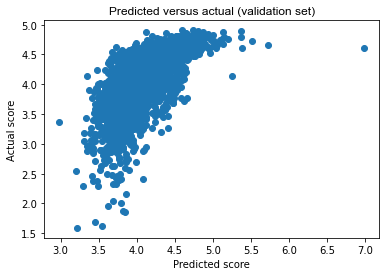

In [23]:
fig, ax = plt.subplots()
plt.scatter(y_pred,y_val)
plt.title('Predicted versus actual (validation set)',family='arial',fontsize=12)
plt.xlabel('Predicted score')
plt.ylabel('Actual score');

This model is overpredicting values

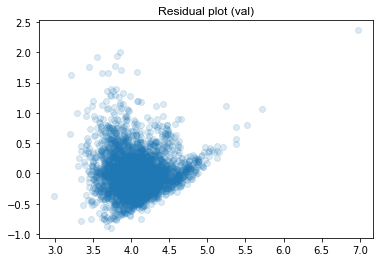

In [24]:
plt.scatter(check['pred'],check['resid'],alpha = 0.15)
plt.title('Residual plot (val)',family='arial',fontsize=12);

## Removing ratings

The sections below iteratively remove features which the model is not using (0.0) or which have very low coefficients. This is to manage for overfitting

In [25]:
features2 = features.copy()
features2.remove('ratings')

In [26]:
lr2 = LinearRegression()

lr2.fit(X_train[features2], y_train)

y_pred2 = lr2.predict(X_val[features2])
print('R^2 of linear regression on val set: {:.2f}'.format(lr2.score(X_val[features2], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred2))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred2))))

R^2 of linear regression on val set: 0.38
MSE of linear regression on val set: 0.12
MAE of linear regression on val set: 0.26


In [27]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features2].columns, lr2.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.13
containsAds : -0.01
editorsChoice : 0.17
top_developer : 0.46
installs_day : 0.00
updated_days : -0.00
has_video : 0.07
compound : 1.15
genre_Adventure : -0.11
genre_Arcade : 0.02
genre_Art & Design : -0.10
genre_Auto & Vehicles : 0.10
genre_Beauty : -0.18
genre_Board : 0.06
genre_Books & Reference : 0.11
genre_Business : 0.08
genre_Card : 0.18
genre_Casino : 0.22
genre_Casual : -0.04
genre_Comics : -0.16
genre_Communication : 0.05
genre_Dating : -0.04
genre_Education : -0.03
genre_Entertainment : -0.06
genre_Events : -0.34
genre_Finance : 0.12
genre_Food & Drink : 0.10
genre_Health & Fitness : 0.10
genre_House & Home : 0.11
genre_Libraries & Demo : -0.03
genre_Lifestyle : -0.02
genre_Maps & Navigation : 0.12
genre_Medical : 0.04
genre_Music & Audio : 0.03
genre_News & Magazines : -0.05
genre_Parenting : 0.03
genre_Personalization : 0.06
genre_Photography : -0.09
genre_Productivity : 0.04
genre_Puzzle : 0.11
genre_Racing : -0.03
genre_Role Pl

In [28]:
check2 = X_val.copy()
check2['score'] = y_val
check2['pred'] = lr2.predict(X_val[features2])
check2['resid'] = check2['pred'] - check2['score']

In [29]:
check2.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,compound,genre_Adventure,...,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020,score,pred,resid
7830,4775.0,1,1,0,0,470.145745,197,1,0.033668,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.851464,3.922196,2.070731
16299,25281.0,1,0,0,0,354.609929,41,0,-0.001986,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.873423,3.826133,1.952710
16322,16079.0,1,1,0,0,298.329356,2442,0,-0.012060,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.626476,3.525210,1.898734
5639,16293.0,1,0,0,0,267.952840,5,0,-0.010455,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.015188,3.852407,1.837219
1320,6117.0,1,1,0,0,1430.615165,194,0,-0.171675,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.696825,3.469369,1.772543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16211,23706.0,1,0,0,0,583.771162,56,0,-0.103322,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.387165,3.598112,-0.789053
14845,244762.0,1,1,0,0,939.849624,27,1,-0.047502,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.514364,3.681953,-0.832411
16610,9503.0,1,1,0,0,677.048070,4,0,0.042221,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.536765,3.691672,-0.845093
2985,7382.0,1,1,0,0,352.360817,14,0,0.053026,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.630582,3.782118,-0.848464


## Removing installs / day

In [30]:
features3 = features2.copy()
features3.remove('installs_day')

In [31]:
lr3 = LinearRegression()

lr3.fit(X_train[features3], y_train)

y_pred3 = lr3.predict(X_val[features3])
print('R^2 of linear regression on val set: {:.2f}'.format(lr3.score(X_val[features3], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred3))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred3))))

R^2 of linear regression on val set: 0.38
MSE of linear regression on val set: 0.12
MAE of linear regression on val set: 0.26


In [32]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features3].columns, lr3.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.12
containsAds : -0.01
editorsChoice : 0.17
top_developer : 0.46
updated_days : -0.00
has_video : 0.07
compound : 1.15
genre_Adventure : -0.11
genre_Arcade : 0.01
genre_Art & Design : -0.10
genre_Auto & Vehicles : 0.10
genre_Beauty : -0.18
genre_Board : 0.06
genre_Books & Reference : 0.11
genre_Business : 0.08
genre_Card : 0.18
genre_Casino : 0.22
genre_Casual : -0.04
genre_Comics : -0.16
genre_Communication : 0.04
genre_Dating : -0.04
genre_Education : -0.03
genre_Entertainment : -0.06
genre_Events : -0.35
genre_Finance : 0.11
genre_Food & Drink : 0.09
genre_Health & Fitness : 0.09
genre_House & Home : 0.10
genre_Libraries & Demo : -0.04
genre_Lifestyle : -0.02
genre_Maps & Navigation : 0.11
genre_Medical : 0.03
genre_Music & Audio : 0.03
genre_News & Magazines : -0.05
genre_Parenting : 0.03
genre_Personalization : 0.06
genre_Photography : -0.09
genre_Productivity : 0.04
genre_Puzzle : 0.11
genre_Racing : -0.03
genre_Role Playing : -0.07
genre_

In [33]:
check3 = X_val.copy()
check3['score'] = y_val
check3['pred'] = lr3.predict(X_val[features3])
check3['resid'] = check3['pred'] - check3['score']

In [34]:
check3.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,compound,genre_Adventure,...,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020,score,pred,resid
7830,4775.0,1,1,0,0,470.145745,197,1,0.033668,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.851464,3.922314,2.070850
16299,25281.0,1,0,0,0,354.609929,41,0,-0.001986,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.873423,3.826593,1.953170
16322,16079.0,1,1,0,0,298.329356,2442,0,-0.012060,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.626476,3.523471,1.896995
5639,16293.0,1,0,0,0,267.952840,5,0,-0.010455,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.015188,3.852738,1.837549
1320,6117.0,1,1,0,0,1430.615165,194,0,-0.171675,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.696825,3.473531,1.776705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16211,23706.0,1,0,0,0,583.771162,56,0,-0.103322,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.387165,3.598507,-0.788658
14845,244762.0,1,1,0,0,939.849624,27,1,-0.047502,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.514364,3.683449,-0.830915
16610,9503.0,1,1,0,0,677.048070,4,0,0.042221,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.536765,3.691530,-0.845234
2985,7382.0,1,1,0,0,352.360817,14,0,0.053026,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.630582,3.782387,-0.848195


## Removing updated days

In [35]:
features4 = features3.copy()
features4.remove('updated_days')

In [36]:
lr4 = LinearRegression()

lr4.fit(X_train[features4], y_train)

y_pred4 = lr4.predict(X_val[features4])
print('R^2 of linear regression on val set: {:.2f}'.format(lr4.score(X_val[features4], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format(mean_squared_error(y_val, y_pred4)))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred4))))

R^2 of linear regression on val set: 0.38
MSE of linear regression on val set: 0.12
MAE of linear regression on val set: 0.26


In [37]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features4].columns, lr4.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.12
containsAds : -0.01
editorsChoice : 0.18
top_developer : 0.46
has_video : 0.07
compound : 1.16
genre_Adventure : -0.11
genre_Arcade : 0.02
genre_Art & Design : -0.09
genre_Auto & Vehicles : 0.11
genre_Beauty : -0.16
genre_Board : 0.08
genre_Books & Reference : 0.13
genre_Business : 0.10
genre_Card : 0.19
genre_Casino : 0.24
genre_Casual : -0.04
genre_Comics : -0.15
genre_Communication : 0.06
genre_Dating : -0.01
genre_Education : -0.01
genre_Entertainment : -0.05
genre_Events : -0.32
genre_Finance : 0.15
genre_Food & Drink : 0.12
genre_Health & Fitness : 0.11
genre_House & Home : 0.13
genre_Libraries & Demo : -0.03
genre_Lifestyle : -0.00
genre_Maps & Navigation : 0.14
genre_Medical : 0.06
genre_Music & Audio : 0.04
genre_News & Magazines : -0.02
genre_Parenting : 0.06
genre_Personalization : 0.07
genre_Photography : -0.08
genre_Productivity : 0.05
genre_Puzzle : 0.12
genre_Racing : -0.03
genre_Role Playing : -0.06
genre_Shopping : 0.17
genre

In [38]:
check3 = X_val.copy()
check3['score'] = y_val
check3['pred'] = lr3.predict(X_val[features3])
check3['resid'] = check3['pred'] - check3['score']

In [39]:
check3.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,compound,genre_Adventure,...,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020,score,pred,resid
7830,4775.0,1,1,0,0,470.145745,197,1,0.033668,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.851464,3.922314,2.070850
16299,25281.0,1,0,0,0,354.609929,41,0,-0.001986,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.873423,3.826593,1.953170
16322,16079.0,1,1,0,0,298.329356,2442,0,-0.012060,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.626476,3.523471,1.896995
5639,16293.0,1,0,0,0,267.952840,5,0,-0.010455,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.015188,3.852738,1.837549
1320,6117.0,1,1,0,0,1430.615165,194,0,-0.171675,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.696825,3.473531,1.776705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16211,23706.0,1,0,0,0,583.771162,56,0,-0.103322,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.387165,3.598507,-0.788658
14845,244762.0,1,1,0,0,939.849624,27,1,-0.047502,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.514364,3.683449,-0.830915
16610,9503.0,1,1,0,0,677.048070,4,0,0.042221,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.536765,3.691530,-0.845234
2985,7382.0,1,1,0,0,352.360817,14,0,0.053026,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.630582,3.782387,-0.848195


## Removing year 2011 and sports

In [40]:
features5 = features4.copy()
features5.remove('year_2011')
features5.remove('genre_Sports')

In [41]:
lr5 = LinearRegression()

lr5.fit(X_train[features5], y_train)

y_pred5 = lr5.predict(X_val[features5])
print('R^2 of linear regression on val set: {:.2f}'.format(lr5.score(X_val[features5], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred5))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred5))))

R^2 of linear regression on val set: 0.38
MSE of linear regression on val set: 0.12
MAE of linear regression on val set: 0.26


In [42]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features5].columns, lr5.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.12
containsAds : -0.01
editorsChoice : 0.18
top_developer : 0.46
has_video : 0.07
compound : 1.16
genre_Adventure : -0.10
genre_Arcade : 0.02
genre_Art & Design : -0.09
genre_Auto & Vehicles : 0.11
genre_Beauty : -0.16
genre_Board : 0.08
genre_Books & Reference : 0.13
genre_Business : 0.10
genre_Card : 0.19
genre_Casino : 0.24
genre_Casual : -0.04
genre_Comics : -0.15
genre_Communication : 0.06
genre_Dating : -0.01
genre_Education : -0.01
genre_Entertainment : -0.05
genre_Events : -0.32
genre_Finance : 0.15
genre_Food & Drink : 0.12
genre_Health & Fitness : 0.12
genre_House & Home : 0.13
genre_Libraries & Demo : -0.03
genre_Lifestyle : -0.00
genre_Maps & Navigation : 0.14
genre_Medical : 0.06
genre_Music & Audio : 0.04
genre_News & Magazines : -0.02
genre_Parenting : 0.06
genre_Personalization : 0.07
genre_Photography : -0.08
genre_Productivity : 0.05
genre_Puzzle : 0.12
genre_Racing : -0.03
genre_Role Playing : -0.06
genre_Shopping : 0.17
genre

In [43]:
check5 = X_val.copy()
check5['score'] = y_val
check5['pred'] = lr5.predict(X_val[features5])
check5['resid'] = check5['pred'] - check5['score']

In [44]:
check5.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,compound,genre_Adventure,...,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020,score,pred,resid
7830,4775.0,1,1,0,0,470.145745,197,1,0.033668,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.851464,3.906940,2.055475
16322,16079.0,1,1,0,0,298.329356,2442,0,-0.012060,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.626476,3.620868,1.994392
16299,25281.0,1,0,0,0,354.609929,41,0,-0.001986,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.873423,3.795033,1.921610
5639,16293.0,1,0,0,0,267.952840,5,0,-0.010455,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.015188,3.840953,1.825765
1320,6117.0,1,1,0,0,1430.615165,194,0,-0.171675,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.696825,3.476747,1.779922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16211,23706.0,1,0,0,0,583.771162,56,0,-0.103322,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.387165,3.587662,-0.799503
14845,244762.0,1,1,0,0,939.849624,27,1,-0.047502,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.514364,3.678288,-0.836076
16610,9503.0,1,1,0,0,677.048070,4,0,0.042221,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.536765,3.687783,-0.848982
2985,7382.0,1,1,0,0,352.360817,14,0,0.053026,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.630582,3.768291,-0.862291


## Removing Lifestyle

In [45]:
features6 = features5.copy()
features6.remove('genre_Lifestyle')

In [46]:
lr6 = LinearRegression()

lr6.fit(X_train[features6], y_train)

y_pred6 = lr6.predict(X_val[features6])
print('R^2 of linear regression on val set: {:.2f}'.format(lr6.score(X_val[features6], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred6))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred6))))

R^2 of linear regression on val set: 0.38
MSE of linear regression on val set: 0.12
MAE of linear regression on val set: 0.26


In [47]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features6].columns, lr6.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.12
containsAds : -0.01
editorsChoice : 0.18
top_developer : 0.46
has_video : 0.07
compound : 1.16
genre_Adventure : -0.10
genre_Arcade : 0.02
genre_Art & Design : -0.09
genre_Auto & Vehicles : 0.12
genre_Beauty : -0.16
genre_Board : 0.08
genre_Books & Reference : 0.13
genre_Business : 0.10
genre_Card : 0.20
genre_Casino : 0.24
genre_Casual : -0.04
genre_Comics : -0.14
genre_Communication : 0.06
genre_Dating : -0.01
genre_Education : -0.01
genre_Entertainment : -0.05
genre_Events : -0.32
genre_Finance : 0.15
genre_Food & Drink : 0.12
genre_Health & Fitness : 0.12
genre_House & Home : 0.13
genre_Libraries & Demo : -0.03
genre_Maps & Navigation : 0.15
genre_Medical : 0.07
genre_Music & Audio : 0.04
genre_News & Magazines : -0.02
genre_Parenting : 0.06
genre_Personalization : 0.07
genre_Photography : -0.08
genre_Productivity : 0.06
genre_Puzzle : 0.13
genre_Racing : -0.03
genre_Role Playing : -0.06
genre_Shopping : 0.17
genre_Simulation : -0.10
genr

In [48]:
check6 = X_val.copy()
check6['score'] = y_val
check6['pred'] = lr6.predict(X_val[features6])
check6['resid'] = check6['pred'] - check6['score']

In [49]:
check6.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,compound,genre_Adventure,...,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020,score,pred,resid
7830,4775.0,1,1,0,0,470.145745,197,1,0.033668,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.851464,3.907114,2.055649
16322,16079.0,1,1,0,0,298.329356,2442,0,-0.012060,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.626476,3.620804,1.994328
16299,25281.0,1,0,0,0,354.609929,41,0,-0.001986,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.873423,3.794857,1.921435
5639,16293.0,1,0,0,0,267.952840,5,0,-0.010455,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.015188,3.840843,1.825654
1320,6117.0,1,1,0,0,1430.615165,194,0,-0.171675,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.696825,3.479924,1.783099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16211,23706.0,1,0,0,0,583.771162,56,0,-0.103322,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.387165,3.587577,-0.799587
14845,244762.0,1,1,0,0,939.849624,27,1,-0.047502,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.514364,3.681580,-0.832784
16610,9503.0,1,1,0,0,677.048070,4,0,0.042221,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.536765,3.687868,-0.848897
2985,7382.0,1,1,0,0,352.360817,14,0,0.053026,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.630582,3.768231,-0.862351


## Removing mature and 2012

In [50]:
features7 = features6.copy()
features7.remove('contentRating_Mature 17+')
features7.remove('year_2012')

In [51]:
lr7 = LinearRegression()

lr7.fit(X_train[features7], y_train)

y_pred7 = lr7.predict(X_val[features7])
print('R^2 of linear regression on val set: {:.2f}'.format(lr7.score(X_val[features7], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred7))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred7))))

R^2 of linear regression on val set: 0.38
MSE of linear regression on val set: 0.12
MAE of linear regression on val set: 0.26


In [52]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features7].columns, lr7.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.12
containsAds : -0.01
editorsChoice : 0.18
top_developer : 0.46
has_video : 0.07
compound : 1.16
genre_Adventure : -0.10
genre_Arcade : 0.02
genre_Art & Design : -0.09
genre_Auto & Vehicles : 0.12
genre_Beauty : -0.16
genre_Board : 0.08
genre_Books & Reference : 0.13
genre_Business : 0.10
genre_Card : 0.20
genre_Casino : 0.24
genre_Casual : -0.04
genre_Comics : -0.15
genre_Communication : 0.06
genre_Dating : -0.02
genre_Education : -0.01
genre_Entertainment : -0.05
genre_Events : -0.32
genre_Finance : 0.15
genre_Food & Drink : 0.12
genre_Health & Fitness : 0.12
genre_House & Home : 0.13
genre_Libraries & Demo : -0.03
genre_Maps & Navigation : 0.15
genre_Medical : 0.07
genre_Music & Audio : 0.04
genre_News & Magazines : -0.02
genre_Parenting : 0.06
genre_Personalization : 0.07
genre_Photography : -0.07
genre_Productivity : 0.06
genre_Puzzle : 0.13
genre_Racing : -0.03
genre_Role Playing : -0.06
genre_Shopping : 0.17
genre_Simulation : -0.10
genr

In [53]:
check7 = X_val.copy()
check7['score'] = y_val
check7['pred'] = lr7.predict(X_val[features7])
check7['resid'] = check7['pred'] - check7['score']

In [54]:
check7.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,compound,genre_Adventure,...,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020,score,pred,resid
7830,4775.0,1,1,0,0,470.145745,197,1,0.033668,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.851464,3.906953,2.055488
16322,16079.0,1,1,0,0,298.329356,2442,0,-0.012060,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.626476,3.624147,1.997671
16299,25281.0,1,0,0,0,354.609929,41,0,-0.001986,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.873423,3.794879,1.921456
5639,16293.0,1,0,0,0,267.952840,5,0,-0.010455,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.015188,3.844276,1.829088
1320,6117.0,1,1,0,0,1430.615165,194,0,-0.171675,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.696825,3.478524,1.781698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16211,23706.0,1,0,0,0,583.771162,56,0,-0.103322,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.387165,3.587155,-0.800009
14845,244762.0,1,1,0,0,939.849624,27,1,-0.047502,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.514364,3.680318,-0.834046
16610,9503.0,1,1,0,0,677.048070,4,0,0.042221,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.536765,3.688210,-0.848554
2985,7382.0,1,1,0,0,352.360817,14,0,0.053026,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.630582,3.767044,-0.863538


## Removing Education

In [55]:
features8 = features7.copy()
features8.remove('genre_Education')

In [56]:
lr8 = LinearRegression()

lr8.fit(X_train[features8], y_train)

y_pred8 = lr8.predict(X_val[features8])
print('R^2 of linear regression on val set: {:.2f}'.format(lr8.score(X_val[features8], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred8))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred8))))

R^2 of linear regression on val set: 0.38
MSE of linear regression on val set: 0.12
MAE of linear regression on val set: 0.26


In [57]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features8].columns, lr8.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.12
containsAds : -0.01
editorsChoice : 0.18
top_developer : 0.46
has_video : 0.07
compound : 1.16
genre_Adventure : -0.10
genre_Arcade : 0.02
genre_Art & Design : -0.09
genre_Auto & Vehicles : 0.12
genre_Beauty : -0.16
genre_Board : 0.08
genre_Books & Reference : 0.14
genre_Business : 0.11
genre_Card : 0.20
genre_Casino : 0.24
genre_Casual : -0.03
genre_Comics : -0.14
genre_Communication : 0.07
genre_Dating : -0.02
genre_Entertainment : -0.04
genre_Events : -0.32
genre_Finance : 0.15
genre_Food & Drink : 0.13
genre_Health & Fitness : 0.12
genre_House & Home : 0.13
genre_Libraries & Demo : -0.02
genre_Maps & Navigation : 0.15
genre_Medical : 0.07
genre_Music & Audio : 0.04
genre_News & Magazines : -0.02
genre_Parenting : 0.06
genre_Personalization : 0.07
genre_Photography : -0.07
genre_Productivity : 0.06
genre_Puzzle : 0.13
genre_Racing : -0.03
genre_Role Playing : -0.06
genre_Shopping : 0.17
genre_Simulation : -0.10
genre_Social : 0.07
genre_St

In [58]:
check8 = X_val.copy()
check8['score'] = y_val
check8['pred'] = lr8.predict(X_val[features8])
check8['resid'] = check8['pred'] - check8['score']

In [59]:
check8.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,compound,genre_Adventure,...,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020,score,pred,resid
7830,4775.0,1,1,0,0,470.145745,197,1,0.033668,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.851464,3.907100,2.055636
16322,16079.0,1,1,0,0,298.329356,2442,0,-0.012060,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.626476,3.624313,1.997837
16299,25281.0,1,0,0,0,354.609929,41,0,-0.001986,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.873423,3.794730,1.921307
5639,16293.0,1,0,0,0,267.952840,5,0,-0.010455,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.015188,3.844312,1.829124
1320,6117.0,1,1,0,0,1430.615165,194,0,-0.171675,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.696825,3.476098,1.779273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16211,23706.0,1,0,0,0,583.771162,56,0,-0.103322,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.387165,3.587141,-0.800023
14845,244762.0,1,1,0,0,939.849624,27,1,-0.047502,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.514364,3.677571,-0.836793
16610,9503.0,1,1,0,0,677.048070,4,0,0.042221,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.536765,3.688527,-0.848238
2985,7382.0,1,1,0,0,352.360817,14,0,0.053026,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.630582,3.766963,-0.863619


## Removing containsAds

In [60]:
features9 = features8.copy()
features9.remove('containsAds')

In [61]:
lr9 = LinearRegression()

lr9.fit(X_train[features9], y_train)

y_pred9 = lr9.predict(X_val[features9])
print('R^2 of linear regression on val set: {:.2f}'.format(lr9.score(X_val[features9], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred9))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred9))))

R^2 of linear regression on val set: 0.38
MSE of linear regression on val set: 0.12
MAE of linear regression on val set: 0.26


In [62]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features9].columns, lr9.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.13
editorsChoice : 0.18
top_developer : 0.46
has_video : 0.07
compound : 1.16
genre_Adventure : -0.10
genre_Arcade : 0.02
genre_Art & Design : -0.09
genre_Auto & Vehicles : 0.12
genre_Beauty : -0.16
genre_Board : 0.08
genre_Books & Reference : 0.14
genre_Business : 0.11
genre_Card : 0.20
genre_Casino : 0.24
genre_Casual : -0.03
genre_Comics : -0.14
genre_Communication : 0.07
genre_Dating : -0.02
genre_Entertainment : -0.04
genre_Events : -0.32
genre_Finance : 0.16
genre_Food & Drink : 0.13
genre_Health & Fitness : 0.12
genre_House & Home : 0.14
genre_Libraries & Demo : -0.02
genre_Maps & Navigation : 0.15
genre_Medical : 0.07
genre_Music & Audio : 0.04
genre_News & Magazines : -0.02
genre_Parenting : 0.07
genre_Personalization : 0.07
genre_Photography : -0.07
genre_Productivity : 0.06
genre_Puzzle : 0.13
genre_Racing : -0.03
genre_Role Playing : -0.06
genre_Shopping : 0.18
genre_Simulation : -0.10
genre_Social : 0.07
genre_Strategy : 0.10
genre_

In [63]:
check9 = X_val.copy()
check9['score'] = y_val
check9['pred'] = lr9.predict(X_val[features9])
check9['resid'] = check9['pred'] - check9['score']

In [64]:
check9.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,compound,genre_Adventure,...,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020,score,pred,resid
7830,4775.0,1,1,0,0,470.145745,197,1,0.033668,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.851464,3.909663,2.058199
16322,16079.0,1,1,0,0,298.329356,2442,0,-0.012060,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.626476,3.626845,2.000369
16299,25281.0,1,0,0,0,354.609929,41,0,-0.001986,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.873423,3.789229,1.915807
5639,16293.0,1,0,0,0,267.952840,5,0,-0.010455,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.015188,3.843354,1.828166
1320,6117.0,1,1,0,0,1430.615165,194,0,-0.171675,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.696825,3.478312,1.781486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16211,23706.0,1,0,0,0,583.771162,56,0,-0.103322,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.387165,3.583012,-0.804153
14845,244762.0,1,1,0,0,939.849624,27,1,-0.047502,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.514364,3.679920,-0.834444
16610,9503.0,1,1,0,0,677.048070,4,0,0.042221,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.536765,3.691103,-0.845661
2985,7382.0,1,1,0,0,352.360817,14,0,0.053026,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.630582,3.768891,-0.861691


## Removing Role playing, Music, Entertainment

In [65]:
features10 = features9.copy()
features10.remove('genre_Role Playing')
features10.remove('genre_Entertainment')

In [66]:
lr10 = LinearRegression()

lr10.fit(X_train[features10], y_train)

y_pred10 = lr10.predict(X_val[features10])
print('R^2 of linear regression on val set: {:.2f}'.format(lr10.score(X_val[features10], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred10))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred10))))

R^2 of linear regression on val set: 0.38
MSE of linear regression on val set: 0.12
MAE of linear regression on val set: 0.26


In [67]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features10].columns, lr10.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.13
editorsChoice : 0.18
top_developer : 0.46
has_video : 0.07
compound : 1.16
genre_Adventure : -0.08
genre_Arcade : 0.04
genre_Art & Design : -0.07
genre_Auto & Vehicles : 0.14
genre_Beauty : -0.14
genre_Board : 0.10
genre_Books & Reference : 0.15
genre_Business : 0.13
genre_Card : 0.21
genre_Casino : 0.26
genre_Casual : -0.02
genre_Comics : -0.13
genre_Communication : 0.08
genre_Dating : -0.00
genre_Events : -0.30
genre_Finance : 0.17
genre_Food & Drink : 0.15
genre_Health & Fitness : 0.14
genre_House & Home : 0.15
genre_Libraries & Demo : -0.01
genre_Maps & Navigation : 0.17
genre_Medical : 0.09
genre_Music & Audio : 0.06
genre_News & Magazines : -0.00
genre_Parenting : 0.08
genre_Personalization : 0.09
genre_Photography : -0.06
genre_Productivity : 0.08
genre_Puzzle : 0.14
genre_Racing : -0.01
genre_Shopping : 0.19
genre_Simulation : -0.09
genre_Social : 0.09
genre_Strategy : 0.12
genre_Tools : 0.08
genre_Travel & Local : 0.04
genre_Trivia :

In [68]:
check10 = X_val.copy()
check10['score'] = y_val
check10['pred'] = lr10.predict(X_val[features10])
check10['resid'] = check10['pred'] - check10['score']

In [69]:
check10.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,compound,genre_Adventure,...,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020,score,pred,resid
7830,4775.0,1,1,0,0,470.145745,197,1,0.033668,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.851464,3.910680,2.059215
16322,16079.0,1,1,0,0,298.329356,2442,0,-0.012060,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.626476,3.627131,2.000655
16299,25281.0,1,0,0,0,354.609929,41,0,-0.001986,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.873423,3.789625,1.916202
5639,16293.0,1,0,0,0,267.952840,5,0,-0.010455,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.015188,3.843191,1.828003
1320,6117.0,1,1,0,0,1430.615165,194,0,-0.171675,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.696825,3.459994,1.763169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16211,23706.0,1,0,0,0,583.771162,56,0,-0.103322,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.387165,3.583278,-0.803886
16610,9503.0,1,1,0,0,677.048070,4,0,0.042221,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.536765,3.690798,-0.845967
14845,244762.0,1,1,0,0,939.849624,27,1,-0.047502,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.514364,3.663396,-0.850968
2985,7382.0,1,1,0,0,352.360817,14,0,0.053026,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.630582,3.769435,-0.861147


## Removing Libraries & Demo

In [70]:
features11 = features10.copy()
features11.remove('genre_Libraries & Demo')

In [71]:
lr11 = LinearRegression()

lr11.fit(X_train[features11], y_train)

y_pred11 = lr11.predict(X_val[features11])
print('R^2 of linear regression on val set: {:.2f}'.format(lr11.score(X_val[features11], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred11))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred11))))

R^2 of linear regression on val set: 0.38
MSE of linear regression on val set: 0.12
MAE of linear regression on val set: 0.26


In [72]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features11].columns, lr11.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.13
editorsChoice : 0.18
top_developer : 0.46
has_video : 0.07
compound : 1.16
genre_Adventure : -0.08
genre_Arcade : 0.04
genre_Art & Design : -0.07
genre_Auto & Vehicles : 0.14
genre_Beauty : -0.14
genre_Board : 0.10
genre_Books & Reference : 0.15
genre_Business : 0.13
genre_Card : 0.21
genre_Casino : 0.26
genre_Casual : -0.02
genre_Comics : -0.13
genre_Communication : 0.08
genre_Dating : -0.00
genre_Events : -0.30
genre_Finance : 0.17
genre_Food & Drink : 0.15
genre_Health & Fitness : 0.14
genre_House & Home : 0.15
genre_Maps & Navigation : 0.17
genre_Medical : 0.09
genre_Music & Audio : 0.06
genre_News & Magazines : -0.00
genre_Parenting : 0.08
genre_Personalization : 0.09
genre_Photography : -0.06
genre_Productivity : 0.08
genre_Puzzle : 0.14
genre_Racing : -0.01
genre_Shopping : 0.19
genre_Simulation : -0.09
genre_Social : 0.09
genre_Strategy : 0.12
genre_Tools : 0.08
genre_Travel & Local : 0.04
genre_Trivia : 0.06
genre_Video Players & Edi

In [73]:
check11 = X_val.copy()
check11['score'] = y_val
check11['pred'] = lr11.predict(X_val[features11])
check11['resid'] = check11['pred'] - check11['score']

In [74]:
check11.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,compound,genre_Adventure,...,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020,score,pred,resid
7830,4775.0,1,1,0,0,470.145745,197,1,0.033668,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.851464,3.910684,2.059220
16322,16079.0,1,1,0,0,298.329356,2442,0,-0.012060,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.626476,3.627118,2.000642
16299,25281.0,1,0,0,0,354.609929,41,0,-0.001986,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.873423,3.789624,1.916201
5639,16293.0,1,0,0,0,267.952840,5,0,-0.010455,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.015188,3.843182,1.827994
1320,6117.0,1,1,0,0,1430.615165,194,0,-0.171675,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.696825,3.459933,1.763108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16211,23706.0,1,0,0,0,583.771162,56,0,-0.103322,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.387165,3.583260,-0.803905
16610,9503.0,1,1,0,0,677.048070,4,0,0.042221,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.536765,3.690795,-0.845970
14845,244762.0,1,1,0,0,939.849624,27,1,-0.047502,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.514364,3.663348,-0.851016
2985,7382.0,1,1,0,0,352.360817,14,0,0.053026,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.630582,3.769434,-0.861148


### Test

In [75]:
X_test_cont = X_test[['free','editorsChoice','top_developer','has_video','compound']]

In [76]:
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(X_test[['genre','contentRating','year']])

ohe_x_test = ohe.transform(X_test[['genre','contentRating','year']])

columns = ohe.get_feature_names(['genre','contentRating','year'])

ohe_x_test_df = pd.DataFrame(ohe_x_test, columns=columns, index=X_test.index)

In [77]:
#Merge cont and cat DFs
combo_test_df = pd.concat([X_test_cont, ohe_x_test_df], axis=1)

In [78]:
y_pred_test = lr9.predict(combo_test_df[features9])
print('R^2 of linear regression on val set: {:.2f}'.format(lr9.score(combo_test_df[features9], y_test)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_test, y_pred_test))))
print('RMSE of linear regression on val set: {:.2f}'.format(np.sqrt(mean_squared_error(y_test, y_pred_test))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_test, y_pred_test))))

R^2 of linear regression on val set: 0.36
MSE of linear regression on val set: 0.13
RMSE of linear regression on val set: 0.36
MAE of linear regression on val set: 0.27


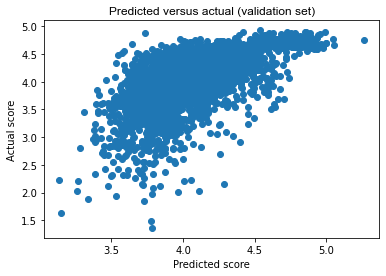

In [79]:
fig, ax = plt.subplots()
plt.scatter(y_pred_test,y_test)
plt.title('Predicted versus actual (validation set)',family='arial',fontsize=12)
plt.xlabel('Predicted score')
plt.ylabel('Actual score');

Great! Model is no longer overfitting